In [ ]:
!unzip /content/drive/MyDrive/DS_audio_cat_dog.zip -d /content/drive/MyDrive/datasetCD_audio_cat_dog

In [6]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_clean_spectrogram(file_path, save_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    # Create a spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plotting the spectrogram without any additional elements
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')  # Don't show axes.
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free memory

# Path to your dataset
path_to_audio_files = '/content/drive/MyDrive/datasetCD_audio_cat_dog/DS_audio_cat_dog'

# Path to save spectrograms
path_to_save_spectrograms = '/content/drive/MyDrive/clean_spectrograms/'

# Ensure the save directory exists, if not, create it
os.makedirs(path_to_save_spectrograms, exist_ok=True)

# Process each file in the dataset
for subfolder in ['cat', 'dog']:
    full_path = os.path.join(path_to_audio_files, subfolder)
    save_folder = os.path.join(path_to_save_spectrograms, subfolder)
    os.makedirs(save_folder, exist_ok=True)  # Create a subfolder for images

    # Process each file in the directory
    for file in os.listdir(full_path):
        if file.endswith('.wav'):  # Check if the file is a WAV file
            file_path = os.path.join(full_path, file)
            save_path = os.path.join(save_folder, f"{os.path.splitext(file)[0]}.png")
            try:
                create_clean_spectrogram(file_path, save_path)
            except Exception as e:
                print(f"Failed to process {file}: {str(e)}")


In [7]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/clean_spectrograms", transform=data_transform)

# Define data loader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=True)
# Remove the last fully connected layer
model = torch.nn.Sequential(*list(model.children())[:-1])
# Set model to evaluation mode
model.eval()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract features and labels
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        features = model(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Flatten features
features = features.view(features.size(0), -1)

# Create pandas DataFrame
df = pd.DataFrame(features.numpy())

# Get folder names to assign labels (0 for 'cat' and 1 for 'dog')
folder_names = dataset.classes
# Assign numerical labels based on folder names
numerical_labels = [0 if folder == 'cat' else 1 for folder in folder_names]
# Assign labels to the DataFrame
df['label'] = [numerical_labels[label] for label in labels]

# Save DataFrame to Excel
df.to_excel('cat_dog_dataset_clean_spectrograms_for_audio.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load Iris dataset from Excel file
data_df = pd.read_excel('/content/cat_dog_dataset_clean_spectrograms_for_audio.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values


print(X.shape)
print(y.shape)

print(X)
print(y)



(277, 2048)
(277,)
[[0.15994872 0.04705508 0.09561326 ... 0.06514841 0.22889939 0.21407561]
 [0.50773197 0.47695974 0.11536323 ... 0.13863191 0.41908047 0.23556629]
 [0.26106015 0.05937244 0.07400312 ... 0.07023224 0.33865488 0.56027234]
 ...
 [0.41640544 0.10614377 0.39206514 ... 0.08650834 0.30595204 0.25226974]
 [0.38757926 0.05950654 0.24142997 ... 0.05013599 0.27050057 0.3083576 ]
 [0.70706856 0.03667315 0.38530323 ... 0.04918545 0.33810985 0.3789416 ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1

(277, 2048)
(277,)
Epoch [50/1000], Loss: 0.3352
Epoch [100/1000], Loss: 0.3227
Epoch [150/1000], Loss: 0.3223
Epoch [200/1000], Loss: 0.3179
Epoch [250/1000], Loss: 0.3136
Epoch [300/1000], Loss: 0.3133
Epoch [350/1000], Loss: 0.3133
Epoch [400/1000], Loss: 0.3133
Epoch [450/1000], Loss: 0.3133
Epoch [500/1000], Loss: 0.3133
Epoch [550/1000], Loss: 0.3133
Epoch [600/1000], Loss: 0.3133
Epoch [650/1000], Loss: 0.3133
Epoch [700/1000], Loss: 0.3133
Epoch [750/1000], Loss: 0.3133
Epoch [800/1000], Loss: 0.3133
Epoch [850/1000], Loss: 0.3133
Epoch [900/1000], Loss: 0.3133
Epoch [950/1000], Loss: 0.3133
Epoch [1000/1000], Loss: 0.3133


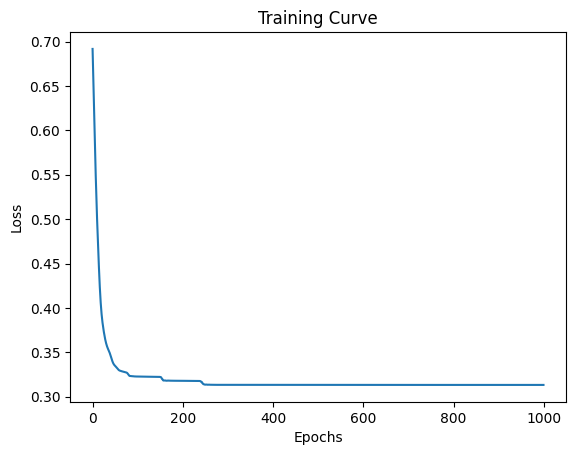

Training Confusion Matrix:
[[131   0]
 [  0  90]]
Training Accuracy: 1.0

Testing Confusion Matrix:
[[33  0]
 [ 4 19]]
Testing Accuracy: 0.9285714285714286


In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset from Excel file
data_df = pd.read_excel('/content/cat_dog_dataset_clean_spectrograms_for_audio.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values

# Apply Min-Max scaling
print(X.shape)
print(y.shape)

# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

# Define training function
def train(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    train_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return train_losses

# Initialize the model, loss function, and optimizer
input_size = 2048
hidden_size1 = 100
hidden_size2 = 50
output_size = 2
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = train(model, criterion, optimizer, X_train, y_train, num_epochs=1000)

# Plot the training curve
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix and accuracy for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())
train_accuracy = accuracy_score(y_train.numpy(), train_predicted.numpy())

print("Training Confusion Matrix:")
print(train_cm)
print("Training Accuracy:", train_accuracy)

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix and accuracy for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())
test_accuracy = accuracy_score(y_test.numpy(), test_predicted.numpy())

print("\nTesting Confusion Matrix:")
print(test_cm)
print("Testing Accuracy:", test_accuracy)


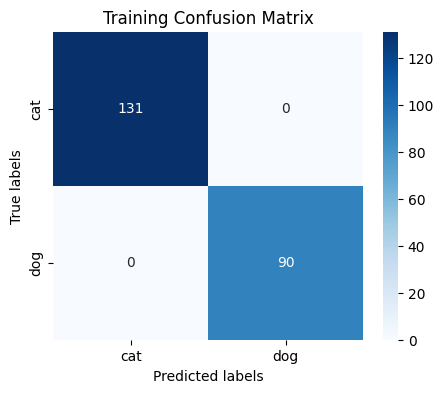

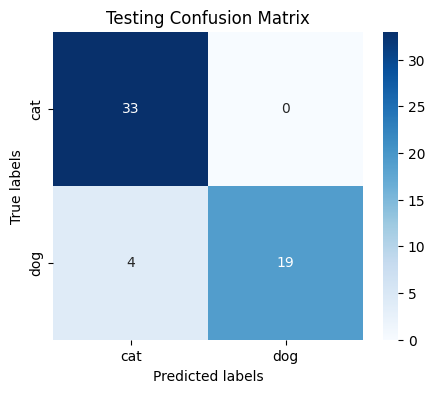

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())

# Plot training confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Training Confusion Matrix')
plt.show()

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())

# Plot testing confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Testing Confusion Matrix')
plt.show()
